In [58]:
import cv2
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as Poly

In [59]:
# %matplotlib notebook

In [60]:
dir_location = 'bdd100k_10k_ins_seg_annotations_coco/'
train_location = 'bdd100k_10k_ins_seg_annotations_coco/train/'

In [63]:
# with open('sample.json', 'r') as f:
#   data = json.load(f)

with open(dir_location + 'ins_seg_train.json', 'r') as f:
    bdd_data = json.load(f)

In [99]:
file_names = []
for idx in range(len(bdd_data)):
    for lab in bdd_data[idx]['labels']:
        if lab['category'] == 'person':
            file_names.append(bdd_data[idx]['name'])
            break

In [97]:
file_names = np.array(file_names, dtype=np.str)
np.savetxt('person.txt', file_names, fmt="%s")
# type(file_names)

numpy.ndarray

In [120]:
for idx, img in enumerate(bdd_data):
    if img['name'] == '1ff407d5-6a60aeeb.jpg':
        print(idx)
        break

603


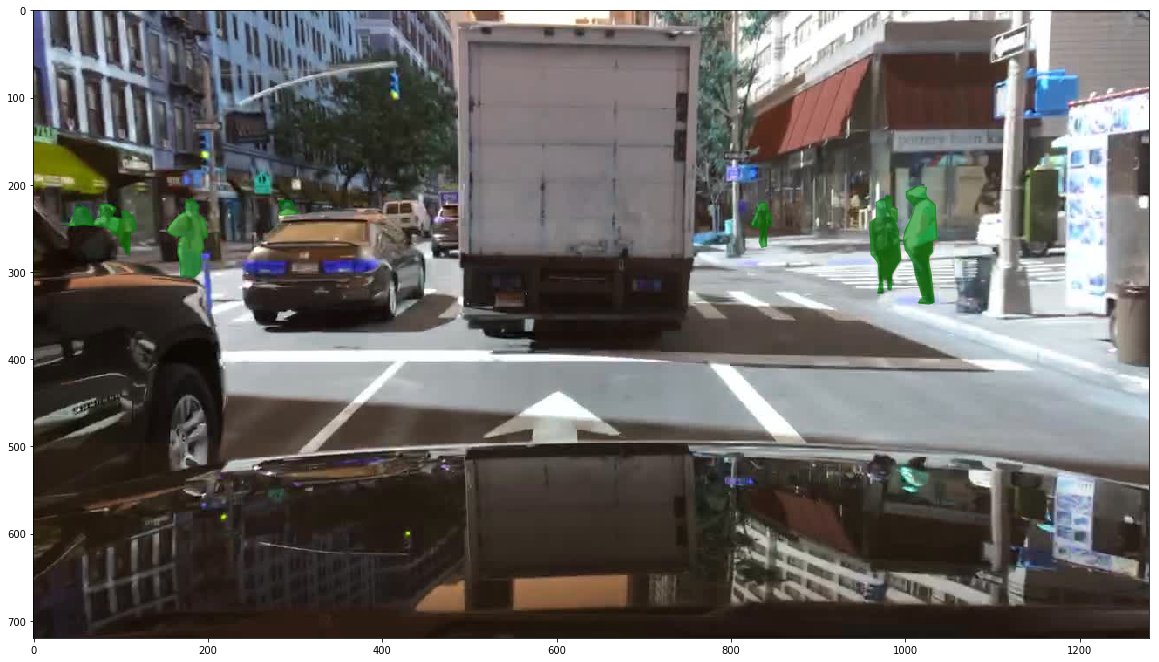

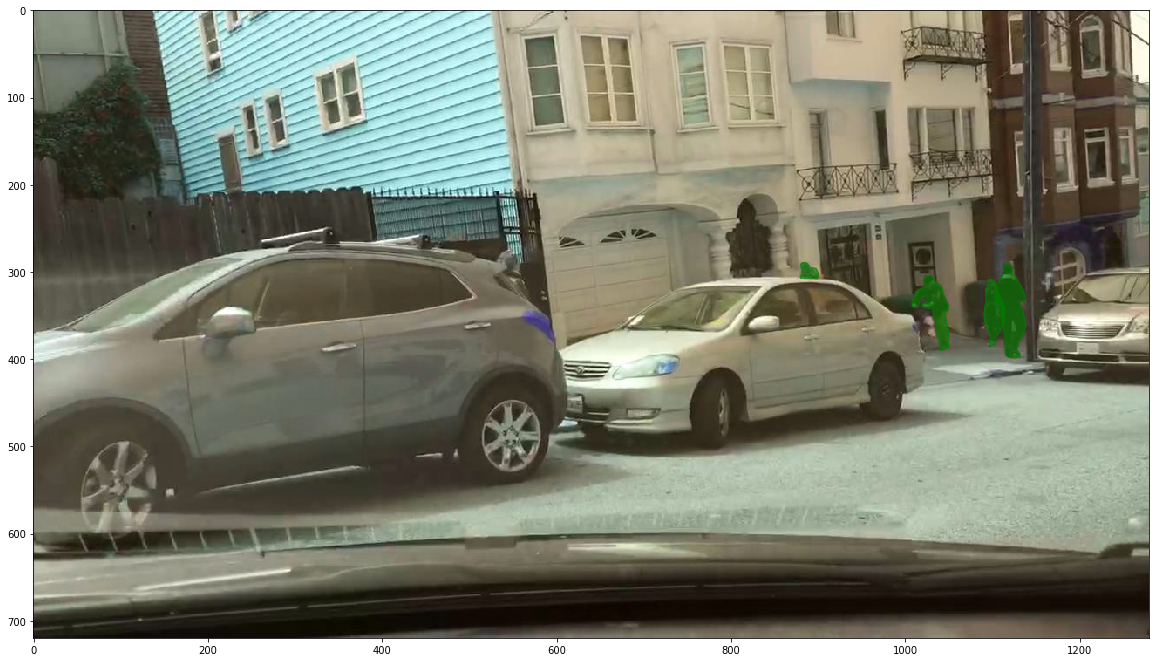

In [150]:
plt.figure(figsize=(20, 20))
ax = plt.subplot()
ax.clear()
img1 = bdd_data[6583]
im1 = cv2.imread(train_location + img1['name'])
plt.imshow(im1)
for idx, an in enumerate(img1['labels']):
    if an['category'] == 'person':
        seg = np.array(an['poly2d'][0]['vertices'])
        segment = Polygon(seg)
        f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
        ax.add_patch(f)
plt.show()

plt.figure(figsize=(20, 20))
ax = plt.subplot()
ax.clear()
img2 = bdd_data[603]
im2 = cv2.imread(train_location + img2['name'])
plt.imshow(im2)
for an in img2['labels']:
    if an['category'] != 'car':
        seg = np.array(an['poly2d'][0]['vertices'])
        segment = Polygon(seg)
        f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
        ax.add_patch(f)
plt.show()

In [151]:
scale_factor = 0.001
area_thresh = im1.shape[0] *  im1.shape[1] * scale_factor

f_high = 1.55
f_low = 0.45

idx_1_2 = []
for idx1, annot1 in enumerate(bdd_data[6583]['labels']):
    if annot1['category'] == 'person':
        seg1 = Polygon(np.array(annot1['poly2d'][0]['vertices']))
        area1 = seg1.area
        if area1 > area_thresh:
            for idx2, annot2 in enumerate(bdd_data[603]['labels']):
                if annot2['category'] == 'person':
                    seg2 = Polygon(np.array(annot2['poly2d'][0]['vertices']))
                    area2 = seg2.area
                    if area2 > area_thresh:
                        f = area1/area2  
                        if f < f_high and f > f_low:
                            idx_1_2.append([idx1, idx2])

idx_1_2 = np.array(idx_1_2)
print('Swappable indices: ', idx_1_2)

('Swappable indices: ', array([[ 5,  1],
       [ 5,  2],
       [11,  1],
       [12,  1],
       [12,  2]]))


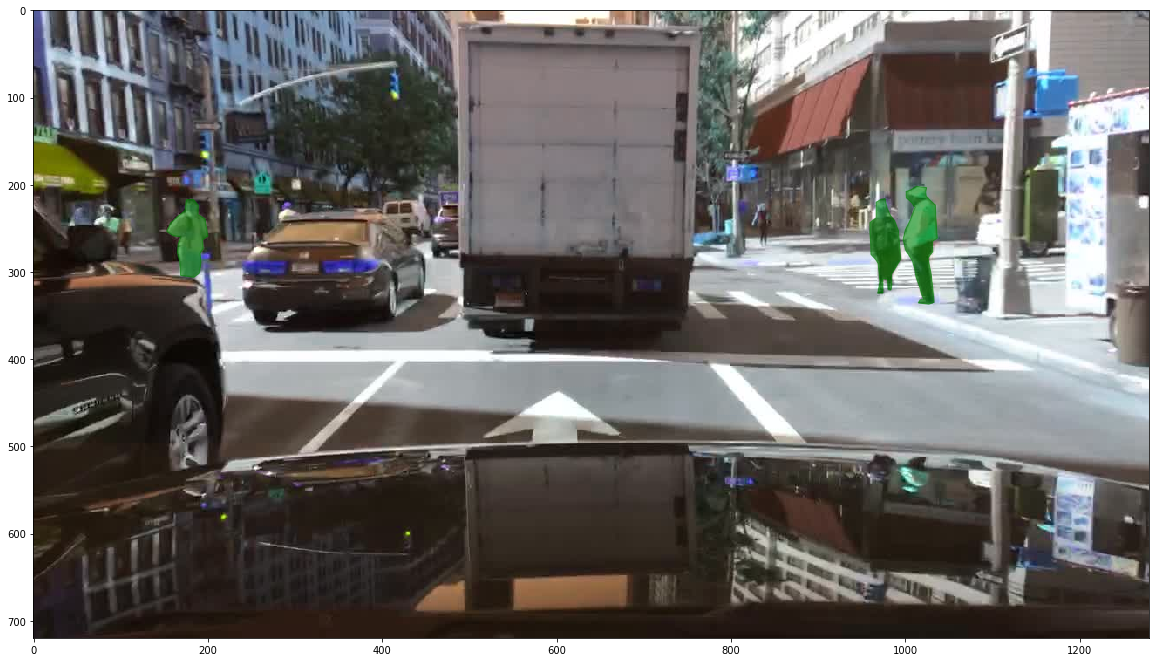

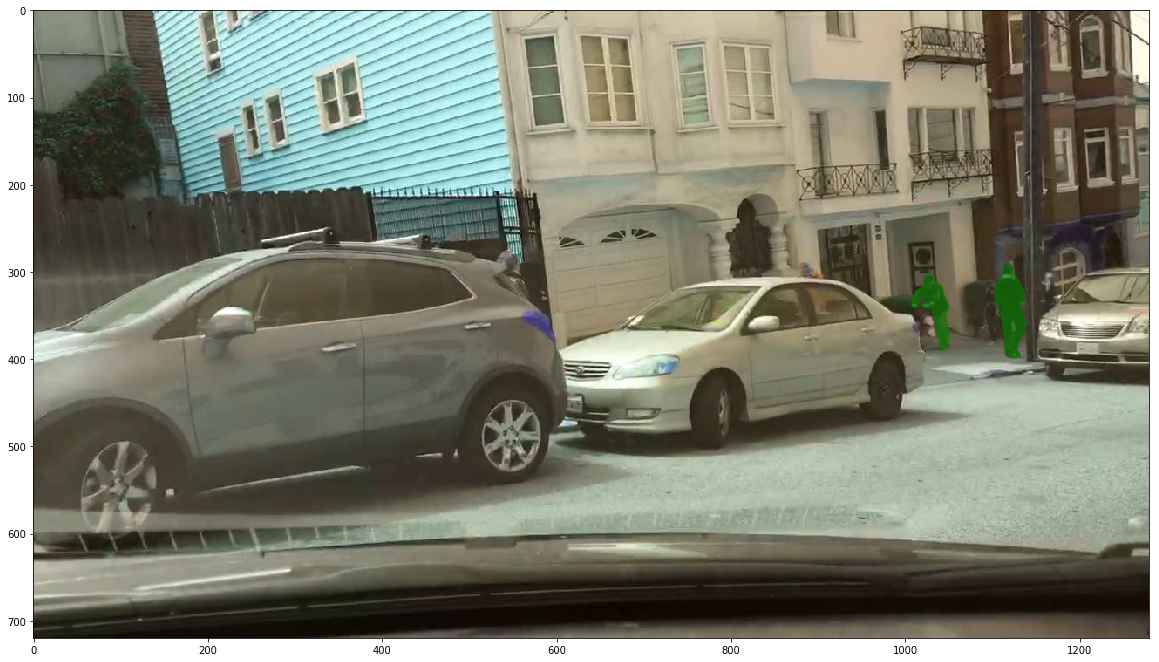

In [155]:
plt.figure(figsize=(20, 20))
ax = plt.subplot()
ax.clear()
img1 = bdd_data[6583]
im1 = cv2.imread(train_location + img1['name'])
plt.imshow(im1)
for idx, an in enumerate(img1['labels']):
    if idx in list(idx_1_2[:,0]):
        seg = np.array(an['poly2d'][0]['vertices'])
        segment = Polygon(seg)
        f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
        ax.add_patch(f)
plt.show()

plt.figure(figsize=(20, 20))
ax = plt.subplot()
ax.clear()
img2 = bdd_data[603]
im2 = cv2.imread(train_location + img2['name'])
plt.imshow(im2)
for idx, an in enumerate(img2['labels']):
    if idx in list(idx_1_2[:,1]):
        seg = np.array(an['poly2d'][0]['vertices'])
        segment = Polygon(seg)
        f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
        ax.add_patch(f)
plt.show()

In [303]:
def swap(i1, i2, idx_1_2, swap_idx):
    
    image1 = cv2.imread(train_location + i1['name'])
    annot1 = i1['labels'][idx_1_2[swap_idx][0]]
    roi_corners1 = np.array([annot1['poly2d'][0]['vertices']], dtype=np.int32)
    roi_mean1 = np.mean(roi_corners1[0], axis=0)
    roi_norm1 = roi_corners1[0] - roi_mean1
    xmin1 = np.min(roi_corners1[0][:,0])
    xmax1 = np.max(roi_corners1[0][:,0])
    ymin1 = np.min(roi_corners1[0][:,1])
    ymax1 = np.max(roi_corners1[0][:,1])
    
    image2 = cv2.imread(train_location + i2['name'])
    annot2 = i2['labels'][idx_1_2[swap_idx][1]]
    roi_corners2 = np.array([annot2['poly2d'][0]['vertices']], dtype=np.int32)
    roi_mean2 = np.mean(roi_corners2[0], axis=0)
    roi_norm2 = roi_corners2[0] - roi_mean2
    xmin2 = np.min(roi_corners2[0][:,0])
    xmax2 = np.max(roi_corners2[0][:,0])
    ymin2 = np.min(roi_corners2[0][:,1])
    ymax2 = np.max(roi_corners2[0][:,1])
    
    mask1 = np.ones(image1.shape, dtype=np.uint8)
    mask1.fill(255)
    cv2.fillPoly(mask1, roi_corners1, 0)
    masked_image1 = cv2.bitwise_or(image1, mask1)
    masking_obj1 = masked_image1[ymin1:ymax1, xmin1:xmax1]
    masked_image1 = np.ones(image2.shape, dtype=np.uint8)
    masked_image1.fill(255)
    masking_obj1 = cv2.resize(masking_obj1, (xmax2-xmin2, ymax2-ymin2), interpolation = cv2.INTER_AREA)
    masked_image1[ymin2:ymax2, xmin2:xmax2] = masking_obj1    
    img2_mask = np.vstack((((xmax2-xmin2)/float(xmax1-xmin1))*roi_norm1[:,0], ((ymax2-ymin2)/float(ymax1-ymin1))*roi_norm1[:,1])).T    
    mask2 = np.ones(image2.shape, dtype=np.uint8)
    mask2.fill(255)
    cv2.fillPoly(mask2, np.array([img2_mask+roi_mean2], dtype=np.int), 0)
    mask2 = 255 - mask2
    masked_image2 = cv2.bitwise_or(image2, mask2)
    mask2 = 255-masked_image1
    mask2[mask2 > 0] = 255
    masked_image2 = cv2.bitwise_or(masked_image2, mask2)
    swapped_1 = cv2.bitwise_and(masked_image1, masked_image2)
    
    mask2 = np.ones(image2.shape, dtype=np.uint8)
    mask2.fill(255)
    cv2.fillPoly(mask2, roi_corners2, 0)
    masked_image2 = cv2.bitwise_or(image2, mask2)
    masking_obj2 = masked_image2[ymin2:ymax2, xmin2:xmax2]
    masked_image2 = np.ones(image1.shape, dtype=np.uint8)
    masked_image2.fill(255)
    masking_obj2 = cv2.resize(masking_obj2, (xmax1-xmin1, ymax1-ymin1), interpolation = cv2.INTER_AREA)
    masked_image2[ymin1:ymax1, xmin1:xmax1] = masking_obj2
    img1_mask = np.vstack((((xmax1-xmin1)/float(xmax2-xmin2))*roi_norm2[:,0], ((ymax1-ymin1)/float(ymax2-ymin2))*roi_norm2[:,1])).T
    mask1 = np.ones(image1.shape, dtype=np.uint8)
    mask1.fill(255)
    cv2.fillPoly(mask1, np.array([img1_mask+roi_mean1], dtype=np.int), 0)
    mask1 = 255 - mask1
    masked_image1 = cv2.bitwise_or(image1, mask1)
    mask1 = 255-masked_image2
    mask1[mask1 > 0] = 255
    masked_image1 = cv2.bitwise_or(masked_image1, mask1)
    swapped_2 = cv2.bitwise_and(masked_image2, masked_image1)
    
    return swapped_1, swapped_2

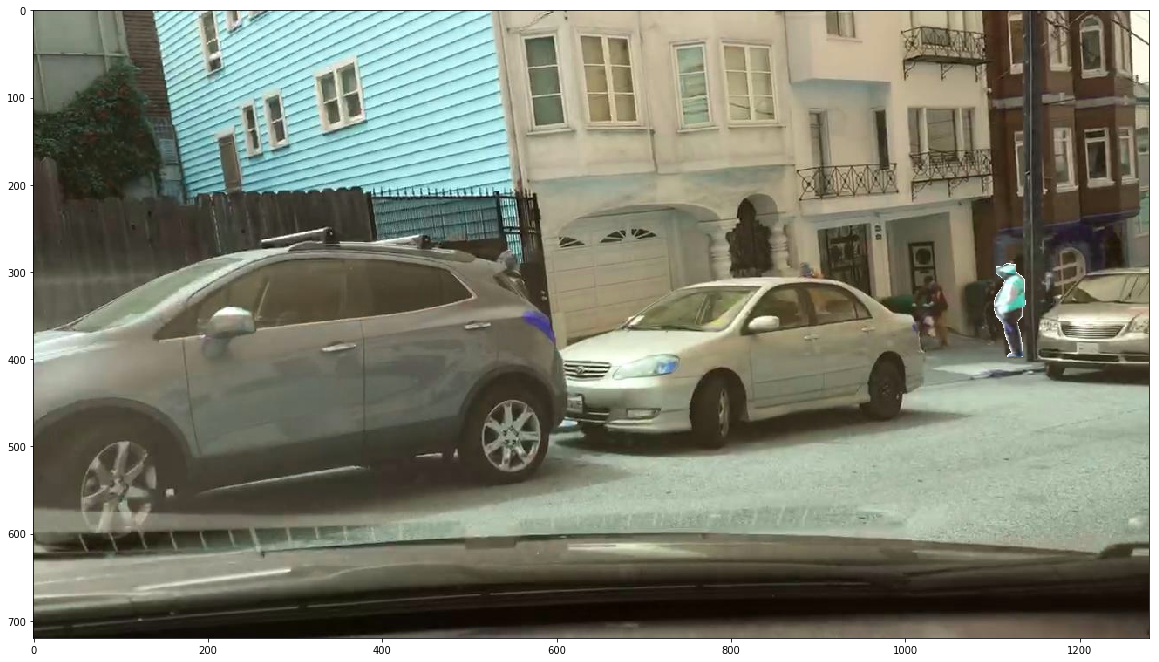

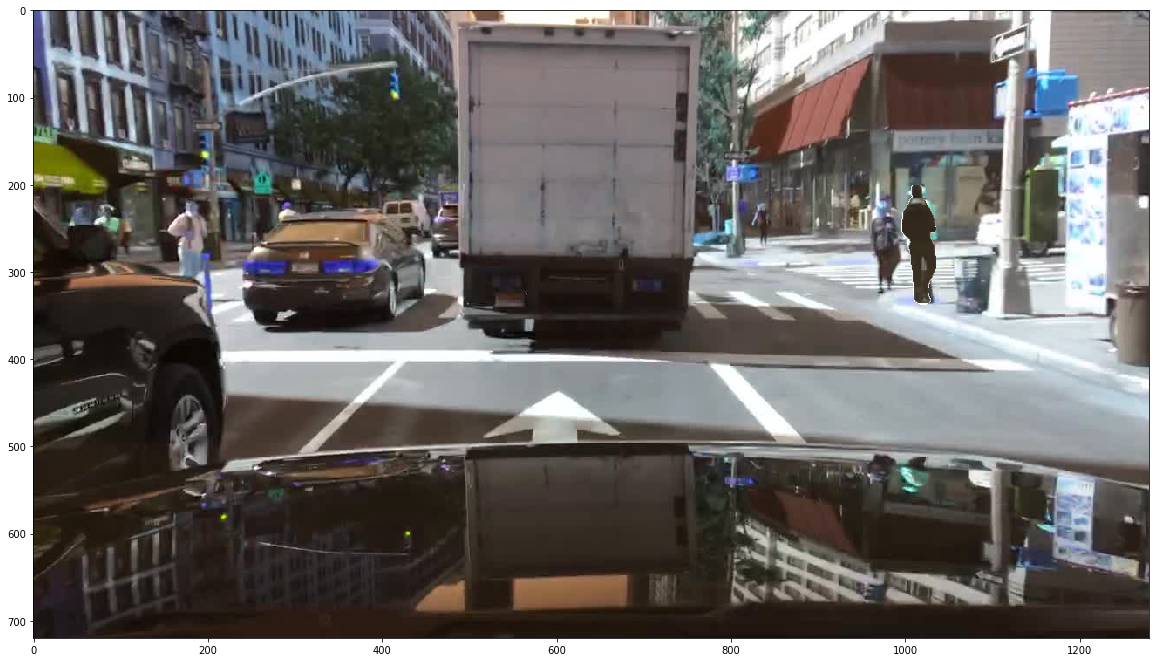

In [304]:
ii1, ii2 = swap(img1, img2, idx_1_2, 2)
plt.figure(figsize=(20, 20))
plt.imshow(ii1)
plt.show()
plt.figure(figsize=(20, 20))
plt.imshow(ii2)
plt.show()

In [ ]:
# class_id , center_x, center_y, width_x, height
